In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from tqdm.auto import tqdm
from multiprocessing import Pool
import itertools
from functools import partial
import scipy.stats as stats

sns.set_context("paper", font_scale=1.7)
sns.set_style("ticks", {"axes.grid": True, "grid.color": "0.95", "grid.linestyle": "-"})

# Data Generation

In [3]:
def diffusive_returns(sigma_f, T, n):
    # Generates diffusive returns with volatility at time t 
    # given by sigma_f(t) for times [0,T] with a total of n observations
    
    # Gap between observations
    delta = T/n
    
    # List of times
    t = np.linspace(0,T,n+1)[:-1]
    sigma = sigma_f(t)

    # Generate Brownian Motion
    dW = np.random.normal(0,1,(n))*np.sqrt(delta)
    r = np.multiply(sigma, dW)
    
    return r

(array([ 421.,  839., 3141., 1791., 2469.,  640.,  551.,   89.,   52.,
           7.]),
 array([ 0. ,  1.5,  3. ,  4.5,  6. ,  7.5,  9. , 10.5, 12. , 13.5, 15. ]),
 <BarContainer object of 10 artists>)

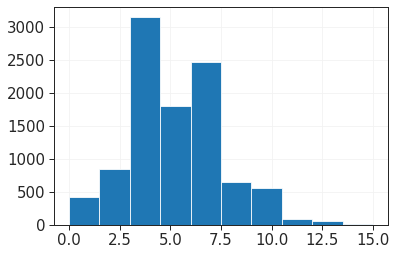

In [4]:
plt.hist(np.random.poisson(5,10000))

In [5]:
def jump_returns(lmb, sigma_jumpsize, T, n):
    # Generates jump returns based on a compound poisson
    # process. Lambda is the frequency of jumps for each 
    # time unit. The standard deviation of the jump size
    # is given by sigma_jumpsize. 
    
    # Sampling times
    t = np.linspace(0,T,n+1)[:-1]
    delta = T/n

    # Total number of jumps
    N = np.random.poisson(lmb*T)
    
    if N == 0:
        return t*0

    # Jump times
    jump_t = np.sort(np.random.rand(N)*T)

    # Size of jumps
    y = np.random.normal(0, sigma_jumpsize, (N))

    # Indicator matrix that jump occured at or after time t
    jump_t_gt_t = np.apply_along_axis(lambda x: x >= t, 1, np.reshape(jump_t, (-1, 1)))

    # Indicator matrix that jump occured strictly before time t
    jump_t_leq_t = np.apply_along_axis(lambda x: x < (t + delta), 1, np.reshape(jump_t, (-1, 1)))

    # Indicator matrix that maps of the jump times to an 
    # interval in [0, delta, 2*delta, ..., T], is an (N*n) matrix
    jump_t_map = jump_t_gt_t & jump_t_leq_t

    # Sums up jumps for each interval: y is (1xN), jump_t_map is (Nxn)
    J = y @ jump_t_map
    
    # Return accumulated jumps
    return J

## Example

In [6]:
sigma_f = lambda x: 3 + x*0
T = 1
n = int(390*60)

diffusive_component = diffusive_returns(sigma_f, T, n)
jump_component = jump_returns(10, 4, T, n)
dX = diffusive_component + jump_component
X = np.cumsum(dX)

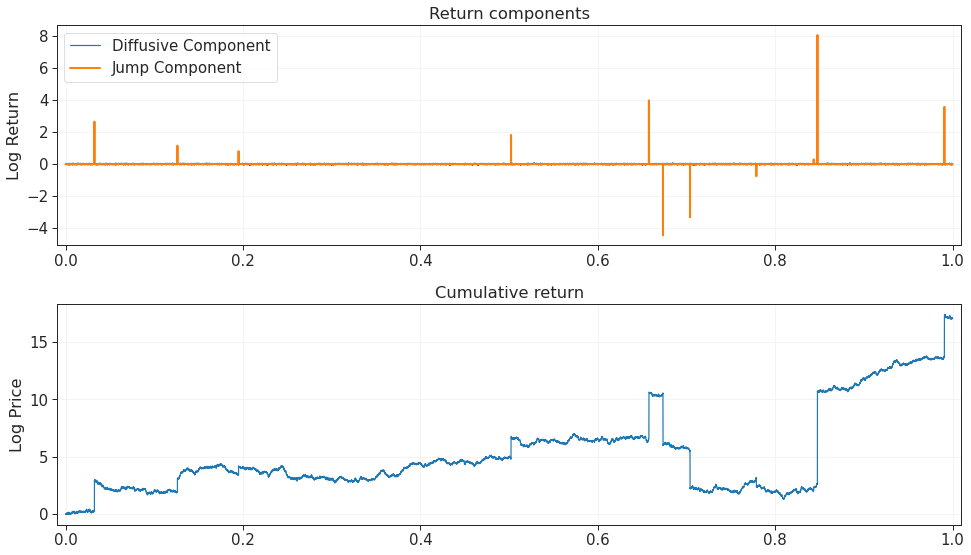

In [7]:
fig, ax = plt.subplots(figsize=(14,8), nrows = 2)
xlims = [-0.01*T, 1.01*T]

ax = plt.subplot(211)
plt.plot(np.linspace(0,T,n+1)[:-1], diffusive_component)
plt.plot(np.linspace(0,T,n+1)[:-1], jump_component, lw = 2)
plt.legend(['Diffusive Component', 'Jump Component'])
plt.title('Return components')
plt.ylabel('Log Return')
plt.xlim(xlims)

ax = plt.subplot(212)
plt.plot(np.linspace(0,T,n+1)[:-1], X)
plt.title('Cumulative return')
plt.ylabel('Log Price')
plt.xlim(xlims)

plt.tight_layout()

# RV Estimation

In [8]:
def estimate_RV(r):
    RV = np.sum(np.square(r))
    se = np.sqrt(2 / 3 * np.sum(np.power(r, 4)))

    return RV, se

In [9]:
def estimate_BV(r):
    n = len(r)
    BV = (np.pi / 2) * (n / (n - 1)) * (np.abs(r[1:]) @ np.abs(r[:-1]))

    return BV

In [10]:
def estimate_TV(r, trim_ind):
    TV = np.square(r) @ trim_ind
    se = np.sqrt(2 / 3 * (np.power(r, 4) @ trim_ind))

    return TV, se

## Simple case: constant local variance and no jumps 

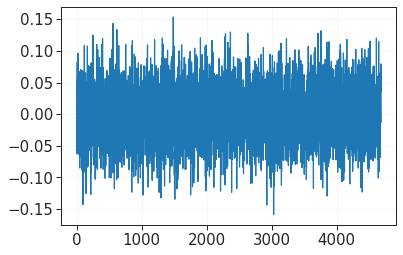

In [11]:
# Time params
T = 1
n = int(390*60/5)

# Process params
sigma_f = lambda x: 3 + x*0
jump_freq = 0.01
sigma_jumpsize = 0


diffusive_component = diffusive_returns(sigma_f, T, n)
jump_component = jump_returns(jump_freq, sigma_jumpsize, T, n)
dX = diffusive_component + jump_component
X = np.cumsum(dX)
plt.plot(dX)

In [12]:
# RV
np.sqrt(estimate_RV(dX)[0]/T)

2.9888992147996896

In [13]:
# Bipower Variance
np.sqrt(estimate_BV(dX)/T)

2.9918571624818173

## Jump case: RV versus BV (RV does bad!)

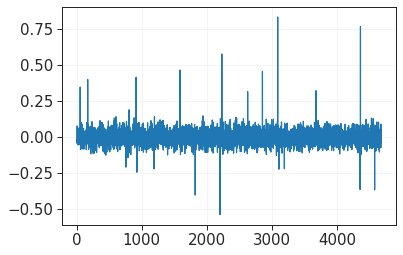

In [14]:
# Time params
T = 1
n = int(390*60/5)

# Process params
sigma_f = lambda x: 3 + x*0
jump_freq = 20
sigma_jumpsize = 0.5


diffusive_component = diffusive_returns(sigma_f, T, n)
jump_component = jump_returns(jump_freq, sigma_jumpsize, T, n)
dX = diffusive_component + jump_component
X = np.cumsum(dX)
plt.plot(dX)

In [15]:
# RV
np.sqrt(estimate_RV(dX)[0]/T)

3.517417593542506

In [16]:
# Bipower Variance
np.sqrt(estimate_BV(dX)/T)

3.0170162123886

## Jump case: BV classifier

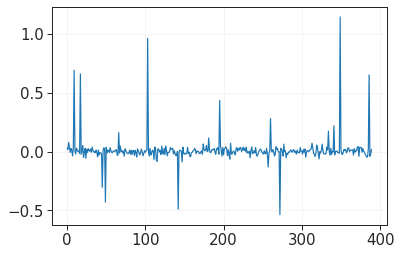

In [51]:
# Time params
T = 1
n = int(390)

# Process params
sigma_f = lambda x: 0.5 + x*0
jump_freq = 20
sigma_jumpsize = 0.5


diffusive_component = diffusive_returns(sigma_f, T, n)
jump_component = jump_returns(jump_freq, sigma_jumpsize, T, n)
dX = diffusive_component + jump_component
X = np.cumsum(dX)
plt.plot(dX)

In [52]:
# As long as T=1, we can fix this to 1
tod_factor = 1

# Cut factors
alpha = 4
BV = estimate_BV(dX)
delta_n = T / n
cut = alpha * np.sqrt(tod_factor * BV) * np.power(delta_n, 0.49)

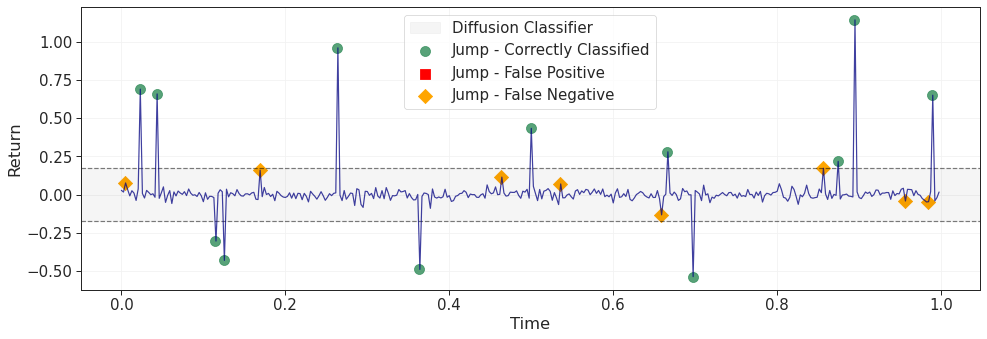

In [53]:
sample_df = pd.DataFrame([np.linspace(0, T, n + 1)[:-1], dX]).T
sample_df.columns = ["t", "dX"]
sample_df["is_jump_hat"] = np.abs(sample_df["dX"]) > cut
sample_df["is_jump_true"] = np.abs(jump_component) > 0
sample_df = sample_df.set_index("t")

plt.figure(figsize=(14, 5))

# Classifier band
plt.axhspan(-cut, cut, 0, T, alpha=0.04, color="k", label="Diffusion Classifier")
plt.axhline(-cut, 0, 1, color = 'k', ls = 'dashed', alpha = 0.5)
plt.axhline(cut, 0, 1, color = 'k', ls = 'dashed', alpha = 0.5)

# Returns
plt.plot(sample_df["dX"], color="navy", alpha=0.75)

# Jump classifications
plt.scatter(
    sample_df.query("is_jump_hat==1 & is_jump_true==1").index-delta_n/4,
    sample_df.query("is_jump_hat==1 & is_jump_true==1")["dX"],
    color="seagreen",
    alpha = 0.8,
    s=100,
    label="Jump - Correctly Classified",
)
plt.scatter(
    sample_df.query("is_jump_hat==1 & is_jump_true==0").index-delta_n/4,
    sample_df.query("is_jump_hat==1 & is_jump_true==0")["dX"],
    color="r",
    marker="s",
    s=100,
    label="Jump - False Positive",
)
plt.scatter(
    sample_df.query("is_jump_hat==0 & is_jump_true==1").index-delta_n/4
    ,
    sample_df.query("is_jump_hat==0 & is_jump_true==1")["dX"],
    color="orange",
    marker="D",
    s=100,
    label="Jump - False Negative",
)

plt.ylabel('Return')
plt.xlabel('Time')
plt.legend()

plt.tight_layout()
plt.savefig('../exhibits/tv_example_classification.pdf')

In [58]:
RV, RV_se = estimate_RV(dX)
BV = np.sqrt(estimate_BV(dX) / T)
print(
    f"RV =       {RV:0.5f}\nse(RV) =   {RV_se:0.4f}"
    + f"\nsqrt(RV) = {np.sqrt(RV):.5}\nse(sqrt(RV)) = {RV_se/np.sqrt(4*RV):.5}"
)

TV, TV_se = estimate_TV(dX, np.abs(dX) <= cut)
print(
    f"TV =       {TV:0.5f}\nse(TV) =   {TV_se:0.4f}\n"
    + f"sqrt(TV) = {np.sqrt(TV):.5}\nse(sqrt(TV)) = {TV_se/np.sqrt(4*TV):.5}"
)

print(f"BV =       {BV:0.5f}\nCut = {cut:0.5f}")

type_i_error = np.mean(np.abs(dX[jump_component != 0]) <= cut)
type_ii_error = np.mean(np.abs(dX[jump_component == 0]) > cut)
print(f"Type I Error:  {type_i_error:.2%}\nType II Error:  {type_ii_error:.2%}")

RV =       5.00514
se(RV) =   1.5009
sqrt(RV) = 2.2372
se(sqrt(RV)) = 0.33545
TV =       0.32638
se(TV) =   0.0414
sqrt(TV) = 0.57129
se(sqrt(TV)) = 0.036266
BV =       0.81171
Cut = 0.17452
Type I Error:  40.00%
Type II Error:  0.00%


# Monte Carlo

In [1302]:
def mc_trial(T, n, sigma_f, jump_freq, sigma_jumpsize):
    
    # Generate data
    np.random.seed()
    diffusive_component = diffusive_returns(sigma_f, T, n)
    jump_component = jump_returns(jump_freq, sigma_jumpsize, T, n)
    dX = diffusive_component + jump_component

    ## RV estimator
    RV, RV_se = estimate_RV(dX)

    ## BV estimator
    BV = estimate_BV(dX)
    
    ## TV estimator
    
    # As long as T=1, we can fix this to 1
    tod_factor = 1
    
    # Cut factors
    alpha = 4
    BV = estimate_BV(dX)
    delta_n = T / n
    cut = alpha * np.sqrt(tod_factor * BV) * np.power(delta_n, 0.49)
    
    
    TV, TV_se = estimate_TV(dX, np.abs(dX) <= cut)
    
    # Oracle info
    temp = np.abs(dX[jump_component != 0]) <= cut
    if len(temp) > 0:
        BV_type_i_error = np.mean(temp)
    else:
        BV_type_i_error = 0
        
    temp = np.abs(dX[jump_component == 0]) > cut
    if len(temp) > 0:
        BV_type_ii_error = np.mean(temp)
    else:
        BV_type_ii_error = 0
        
    # Oracle RV estimator
    RV_oracle, RV_oracle_se = estimate_RV(diffusive_component)
    
    
    return [RV, RV_se, BV, TV, TV_se, BV_type_i_error, BV_type_ii_error, RV_oracle, RV_oracle_se]

In [1303]:
def monte_carlo(params, mc_trials = 1):
    # Given a list of parameters, runs mc_trial replications on them
    # and returns the params and monte carlo results

    # Params
    T, n, sigma_f, jump_freq, sigma_jumpsize = params
    
    # For storing results from each trial
    mc_results = []

    for i in range(mc_trials):
        results = mc_trial(T, n, sigma_f, jump_freq, sigma_jumpsize)
        mc_results.append(results)
        
    return params, mc_results

In [1304]:
## DGP Parameters
# Length of time
T = 1

# Evolution of volatility
def sigma_f(x):
    return 0*x + 0.5

# Range of n to consider
n_range = [int(x) for x in [390*(60/5), 390*(60/15), 390*(60/30), 390, 390/3, 390/5, 390/10, 390/15, 390/30]]

# Range of jump frequencies to consider
jf_range = [2,4,6,8,10]

# Range of sigma jump sizes to consider
sjs_range = [0.5, 1, 1.5, 2, 2.5]

# Unique combination of each parameter
params_list = list(itertools.product([T], n_range, [sigma_f], jf_range, sjs_range))

## Monte Carlo Set Up
# Monte Carlo trials
mc_trials = 1000

# Partial function that runs a Monte Carlo with "mc_trials" replications
# when passed parameters
monte_carlo_mctrials = partial(monte_carlo, mc_trials = mc_trials)

# For storing the output of the results for each trial
results_list = []

with Pool(8) as p:
    for mc_trial_result in tqdm(
        p.imap_unordered(monte_carlo_mctrials, params_list),
                total=len(params_list),
                desc="Running MC trials...",
            ):

        results_list.append(list(mc_trial_result[0]) + list(np.array(mc_trial_result[1]).T))

## Clean Results

In [1305]:
# Set up dataframe
results_df = pd.DataFrame(results_list)
results_df.columns = [
    "T",
    "n",
    "sigma_f",
    "jump_freq",
    "sigma_jumpsize",
    "RV",
    "RV_se",
    "BV",
    "TV",
    "TV_se",
    "BV_type_i_error",
    "BV_type_ii_error",
    "RV_oracle",
    "RV_oracle_se",
]
results_df

,T,n,sigma_f,jump_freq,sigma_jumpsize,RV,RV_se,BV,TV,TV_se,BV_type_i_error,BV_type_ii_error,RV_oracle,RV_oracle_se
0,1,4680,<function sigma_f at 0x7f4be523d400>,2,2.0,"[6.763653830368979, 5.861594108551999, 12.7480...","[4.414790235182839, 3.939950065360431, 6.65366...","[0.2993907205344045, 0.3077953497472508, 0.303...","[0.253697612825865, 0.25536965105782805, 0.249...","[0.005228154926963225, 0.005278947012095903, 0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.2536989623553248, 0.2554337485065867, 0.249...","[0.00522815502641228, 0.005279176837599468, 0...."
1,1,4680,<function sigma_f at 0x7f4be523d400>,2,2.5,"[6.250286248539295, 4.458882835703615, 21.7911...","[3.30663743401329, 2.8392565778065983, 16.1257...","[0.32185172474496815, 0.2925899233157391, 0.32...","[0.2455331491474024, 0.25377282847169064, 0.24...","[0.005073739064209325, 0.00533641955740745, 0....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.24564071014643363, 0.25389884797001705, 0.2...","[0.005074096915031593, 0.0053373685724865845, ..."
2,1,4680,<function sigma_f at 0x7f4be523d400>,2,1.0,"[0.29799854174510076, 0.7807267120721775, 2.08...","[0.04199321210958805, 0.33404305573983, 1.0626...","[0.25690821570339584, 0.27775340337655474, 0.2...","[0.2469551333984601, 0.2551736770850999, 0.254...","[0.005145565034044405, 0.005263570609227649, 0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0002136752136...","[0.24695532257662334, 0.25521412132963767, 0.2...","[0.0051455650363628, 0.005263646668532401, 0.0..."
3,1,4680,<function sigma_f at 0x7f4be523d400>,2,1.5,"[2.71575657615713, 1.4476309032867227, 0.25559...","[1.873939542579623, 0.9747411342435764, 0.0052...","[0.30113813796671335, 0.2734634454709876, 0.25...","[0.24961105054857027, 0.25383915568691723, 0.2...","[0.005181576363819119, 0.005271403499585131, 0...","[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.24969440679246327, 0.25389323234376215, 0.2...","[0.005182005025922056, 0.005271588411347068, 0..."
4,1,4680,<function sigma_f at 0x7f4be523d400>,2,0.5,"[0.24771204401360708, 0.3158910614857623, 0.25...","[0.005035436340886419, 0.050820475636533344, 0...","[0.24840137568000062, 0.2590381234061797, 0.25...","[0.24771204401360708, 0.25397974799667716, 0.2...","[0.00503543634088642, 0.005232614256846645, 0....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.24771204401360708, 0.25398697684681193, 0.2...","[0.005035436340886419, 0.005232617585728096, 0..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
220,1,13,<function sigma_f at 0x7f4be523d400>,10,0.5,"[3.1806447878822692, 3.4080149893900256, 2.758...","[1.181723703691217, 1.7472849019969898, 1.7291...","[1.6839825399539292, 2.708369831738003, 1.2844...","[3.1806447878822692, 3.4080149893900256, 0.659...","[1.181723703691217, 1.7472849019969898, 0.2276...","[1.0, 1.0, 0.8571428571428571, 1.0, 1.0, 0.857...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.3206044532353903, 0.20459810120721333, 0.45...","[0.125251090429299, 0.07204946728766236, 0.140..."
221,1,13,<function sigma_f at 0x7f4be523d400>,10,1.0,"[10.34053039156255, 5.412858503945889, 25.1636...","[3.6546543194049907, 2.5275938164878067, 17.53...","[10.237288204121516, 1.486753205380064, 4.6092...","[10.34053039156255, 2.8306453876678552, 3.8178...","[3.6546543194049907, 1.3940997510562803, 1.951...","[1.0, 0.8571428571428571, 0.75, 1.0, 1.0, 0.71...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.25815139492724076, 0.23756028849582453, 0.3...","[0.08728513626925481, 0.08541431466297658, 0.1..."
222,1,13,<function sigma_f at 0x7f4be523d400>,10,1.5,"[6.9039468692801425, 19.570490312804974, 24.36...","[2.851165846608491, 8.192974351505827, 10.8062...","[3.6930580897128373, 9.92

In [1306]:
# Get Delta_n in minutes
results_df['Delta_n'] = (390/results_df['n']).round(2)

# Get Average Type I and Type II error for BV
results_df["BV_avg_t1"] = results_df["BV_type_i_error"].apply(lambda x: np.mean(x))
results_df["BV_avg_t2"] = results_df["BV_type_ii_error"].apply(lambda x: np.mean(x))

# Get IV for each sigma_f
results_df["IV"] = (
    results_df["sigma_f"]
    .apply(lambda f: np.sum(np.power(f(np.linspace(0, 1, 99999)), 2)) / 99999)
    .round(4)
)

# Get Bias for each estimator
results_df["Bias_RV"] = results_df.apply(lambda row: np.mean(row.RV - row.IV), axis=1)
results_df["Bias_TV"] = results_df.apply(lambda row: np.mean(row.TV - row.IV), axis=1)
results_df["Bias_RV_oracle"] = results_df.apply(lambda row: np.mean(row.RV_oracle - row.IV), axis=1)

# Get RMSE for each estimator
results_df["RMSE_RV"] = results_df.apply(
    lambda row: np.sqrt(np.mean(np.square(row.RV - row.IV))), axis=1
)
results_df["RMSE_TV"] = results_df.apply(
    lambda row: np.sqrt(np.mean(np.square(row.TV - row.IV))), axis=1
)
results_df["RMSE_RV_oracle"] = results_df.apply(
    lambda row: np.sqrt(np.mean(np.square(row.RV_oracle - row.IV))), axis=1
)

# Get Avg StdErr for each estimator
results_df["Mean_RV_se"] = results_df["RV_se"].apply(lambda x: np.mean(x))
results_df["Mean_TV_se"] = results_df["TV_se"].apply(lambda x: np.mean(x))
results_df["Mean_RV_oracle_se"] = results_df["RV_oracle_se"].apply(lambda x: np.mean(x))

# Get Avg StdErr for each estimator
results_df["tstats_RV"] = results_df.apply(lambda row: np.divide(row.RV - row.IV, row.RV_se), axis=1)
results_df["tstats_TV"] = results_df.apply(lambda row: np.divide(row.TV - row.IV, row.TV_se), axis=1)
results_df["tstats_RV_oracle"] = results_df.apply(
    lambda row: np.divide(row.RV_oracle - row.IV, row.RV_oracle_se), axis=1
)

# Coverage rates
for estimator in ["RV", "TV", "RV_oracle"]:
    for conf in [90, 95, 99]:
        results_df[f"coverage_{conf}_{estimator}"] = results_df["tstats_" + estimator].apply(
            lambda x: np.mean(np.abs(x) < stats.norm.ppf(1 - (1 - (conf / 100)) / 2))
        )

results_df.query("sigma_jumpsize == 2.5 & jump_freq == 6").sort_values("n", ascending=True)

,T,n,sigma_f,jump_freq,sigma_jumpsize,RV,RV_se,BV,TV,TV_se,...,tstats_RV_oracle,coverage_90_RV,coverage_95_RV,coverage_99_RV,coverage_90_TV,coverage_95_TV,coverage_99_TV,coverage_90_RV_oracle,coverage_95_RV_oracle,coverage_99_RV_oracle
215,1,13,<function sigma_f at 0x7f4be523d400>,6,2.5,"[26.928391883701536, 19.410943346304, 41.53641...","[15.13357667817555, 9.187912360575785, 24.0371...","[9.701507470469082, 18.236437309847155, 3.9667...","[10.505517841979012, 19.410943346304, 0.150369...","[7.015550480708071, 9.187912360575785, 0.05104...",...,"[0.30716352622912874, -0.1198326611640209, -0....",0.287,0.594,0.970,0.358,0.596,0.951,0.845,0.876,0.915
189,1,26,<function sigma_f at 0x7f4be523d400>,6,2.5,"[58.98261900317234, 52.33943060953626, 33.8408...","[33.03194741750181, 24.836045469490013, 17.374...","[3.714390571012754, 39.06343764709463, 2.69605...","[0.33948817371604867, 52.33943060953626, 0.229...","[0.1020426254873793, 24.836045469490013, 0.064...",...,"[1.11651467055637, 0.2641680587649587, -0.3142...",0.216,0.501,0.934,0.473,0.666,0.931,0.851,0.897,0.950
164,1,39,<function sigma_f at 0x7f4be523d400>,6,2.5,"[26.07385961630092, 97.99922034303543, 50.6461...","[12.994873796992984, 47.87415897648298, 24.918...","[2.8667383199582583, 4.584550602967187, 5.3012...","[1.028358427821232, 1.0608738748007724, 3.7643...","[0.6747848873224603, 0.698607830943634, 1.7234...",...,"[-0.09105528990794587, 0.37311291399736, -2.27...",0.202,0.473,0.903,0.584,0.746,0.944,0.875,0.912,0.966
140,1,78,<function sigma_f at 0x7f4be523d400>,6,2.5,"[56.85015072941055, 51.80123523617784, 13.5550...","[24.0269323683809, 23.96300574642695, 7.383668...","[2.39568413890648, 4.1087570106660385, 1.26035...","[0.25799876257967747, 1.6891308406644578, 0.35...","[0.054336192475828916, 0.7065683445396034, 0.1...",...,"[0.2755484224936655, -0.6770884726980072, -1.0...",0.203,0.487,0.907,0.746,0.877,0.977,0.894,0.937,0.978
114,1,130,<function sigma_f at 0x7f4be523d400>,6,2.5,"[21.57851359952717, 74.60175302837985, 34.6317...","[9.717740963047463, 30.615027115080434, 14.851...","[1.5931071428218166, 13.972086054638817, 2.119...","[0.27449925532138164, 2.844141871861652, 0.247...","[0.036169015149191054, 1.506734049242663, 0.02...",...,"[1.1059800104419424, 0.12089999331896198, 0.29...",0.210,0.445,0.891,0.824,0.915,0.981,0.887,0.937,0.983
89,1,390,<function sigma_f at 0x7f4be523d400>,6,2.5,"[4.020992079565302, 87.1812179670068, 70.21214...","[2.2991305705762977, 40.808816322071294, 26.13...","[0.47178470770012126, 1.4639228671778302, 1.90...","[0.26604712985713547, 0.2690272101098907, 0.25...","[0.019341720623155326, 0.029537699401128204, 0...",...,"[0.9743481343618334, -0.29788365518342, 0.4888...",0.210,0.449,0.887,0.885,0.950,0.983,0.896,0.940,0.984
63,1,780,<function sigma_f at 0x7f4be523d400>,6,2.5,"[69.68441238629396, 27.465504954491866, 60.432...","[37.12931041571514, 14.164781749731048, 22.277...","[1.2589926110379388, 1.0823630247940617, 1.055...","[0.23808988413246707, 0.26369249176358356, 0.2...","[0.011698919468461324, 0.013110927099026884, 0...",...,"[-0.7476256539683362, 1.0963635151428355, 1.16...",0.178,0.441,0.862,0.895,0.941,0.988,0.896,0.954,0.986
39,1,1560,<function sigma_f at 0x7f4be523d400>,6,2.5,"[67.6381142828698, 76.53979813361477, 29.83933...","[31.78114081651648, 38.64898728934789, 16.6566...","[1.0094198489243973, 0.7237746196801332, 0.693...","[0.2473088400484966, 0.24590136703803162, 0.25...","[0.008877682010147768, 0.008857006484969655, 0...",...,"[-0.18158811758567595, -0.3841864750872723, 0....",0.207,0.457,0.874,0.903,0.955,0.991,0.907,0.957,0.993
14,1,4680,<function sigma_f at 0x7f4be523d400>,6,2.5,"[32.755689992738134, 31.720453101090808, 25.41...","[15.956682268377538, 16.381090826208656, 18.32...","[0.44131538081210187, 0.5198119486108131, 0.36...","[0.25398991887970157, 0.24711519503066678, 0.2...","[0.005395290768332579, 0.0051278169347371205, ...",...,"[0.78174314267757, -0.5242452899337071, 0.3229...",0.212,0.485,0.896

## Results
**TV versus RV**
* How does n affect each?
* How does jump freq ...
* How does jump size ..

**BV cuts**
* How does n, jump freq, jump size affect type i and ii error?

### Baseline specification

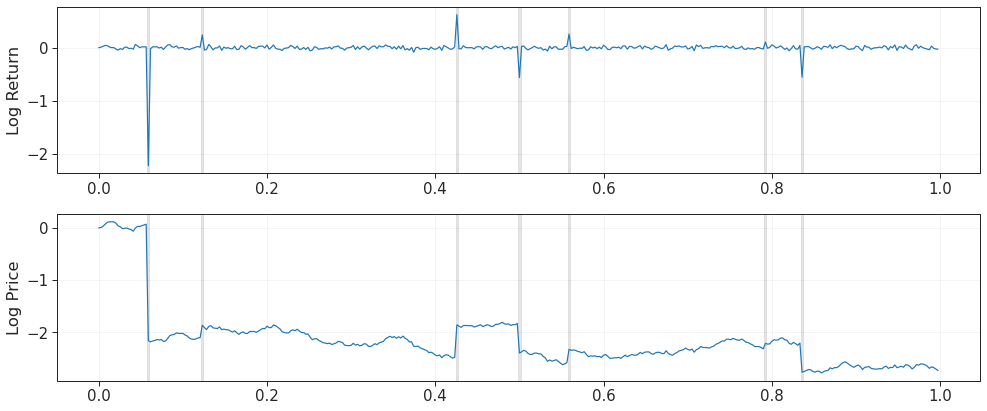

In [1307]:
## Baseline values
# Keep parameters fixed at these values when testing others
params_baseline = {'n': int(390/5), 'jump_freq': 6, 'sigma_jumpsize': 1, 'sigma_f': lambda x: 0.5}

## What does DGP at these values look like?
# Time params
T = 1
n = int(390)

# Process params
sigma_f = params_baseline['sigma_f']
jump_freq = params_baseline['jump_freq']
sigma_jumpsize = params_baseline['sigma_jumpsize']

diffusive_component = diffusive_returns(sigma_f, T, n)
jump_component = jump_returns(jump_freq, sigma_jumpsize, T, n)
dX = diffusive_component + jump_component
X = np.cumsum(dX)

plt.subplots(figsize=(14,6), nrows = 2)

def highlight_jumps():
    delta_n = T/n
    for i in range(n):
        if (jump_component[i] != 0):
            t = np.linspace(0,T,n+1)[:-1][i]
            plt.axvspan(t-delta_n/2, t+delta_n/2, 0, 1, color = 'k', alpha = 0.1)
    

ax = plt.subplot(211)
plt.plot(np.linspace(0,T,n+1)[:-1], dX)
plt.ylabel('Log Return')
highlight_jumps()

ax = plt.subplot(212)
plt.plot(np.linspace(0,T,n+1)[:-1], X)
plt.ylabel('Log Price')
highlight_jumps()

plt.tight_layout()
plt.savefig('../exhibits/dgp_example.pdf')

## Plots

### Singles

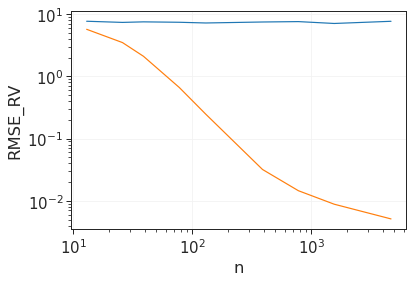

In [1308]:
## Vary n on x-axis

plot_data = results_df.query(
    'jump_freq == @params_baseline.get("jump_freq") '
    + '& sigma_jumpsize == @params_baseline.get("sigma_jumpsize")'
)

sns.lineplot(x="n", y="RMSE_RV", data=plot_data)
sns.lineplot(x="n", y="RMSE_TV", data=plot_data)

plt.yscale('log')
plt.xscale('log')

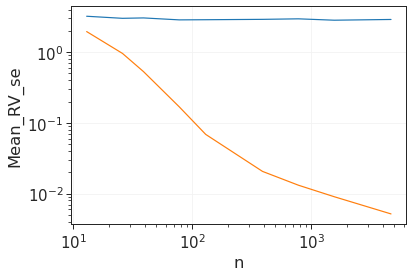

In [1309]:
## Vary n on x-axis

plot_data = results_df.query(
    'jump_freq == @params_baseline.get("jump_freq") '
    + '& sigma_jumpsize == @params_baseline.get("sigma_jumpsize")'
)

sns.lineplot(x="n", y="Mean_RV_se", data=plot_data)
sns.lineplot(x="n", y="Mean_TV_se", data=plot_data)

plt.yscale('log')
plt.xscale('log')

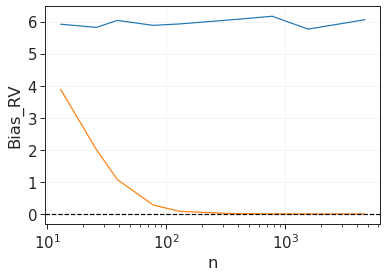

In [1310]:
## Vary n on x-axis

plot_data = results_df.query(
    'jump_freq == @params_baseline.get("jump_freq") '
    + '& sigma_jumpsize == @params_baseline.get("sigma_jumpsize")'
)

sns.lineplot(x="n", y="Bias_RV", data=plot_data)
sns.lineplot(x="n", y="Bias_TV", data=plot_data)
plt.axhline(0, 0, 1, color="k", ls="dashed")

plt.xscale("log")

### Cross-sections

**RMSE**

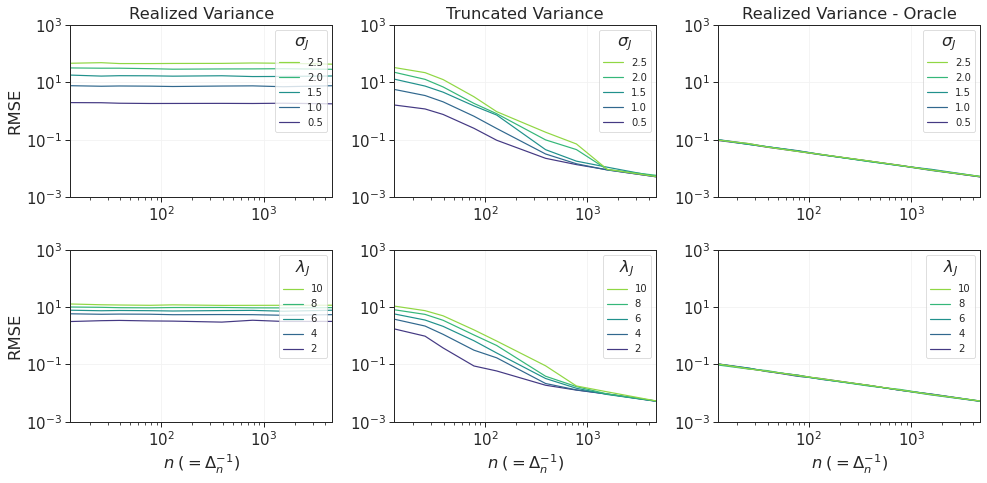

In [1335]:
fig, ax = plt.subplots(figsize=(14, 7), nrows=2, ncols=3)
xlims = [results_df["n"].min(), results_df["n"].max()]
ylims = [10e-4, 10e2]


def plot_helper(ax, x, y, z, plot_data, legend_title, plot_title, y_label, x_label):
    sns.lineplot(
        x=x,
        y=y,
        hue=z,
        palette=sns.color_palette("viridis", len(plot_data[z].unique())),
        data=plot_data,
        ax=ax,
    )
    handles, labels = ax.get_legend_handles_labels()
    plt.legend(handles[::-1], labels[::-1], title=legend_title, fontsize=10, loc="upper right")
    plt.yscale("log")
    plt.xscale("log")
    plt.title(plot_title)
    plt.ylabel(y_label)
    plt.xlabel(x_label)
    plt.xlim(xlims)
    plt.ylim(ylims)


## Vary n on x-axis, vary jump stdev
plot_data = results_df.query('jump_freq == @params_baseline.get("jump_freq")')

plot_helper(
    plt.subplot(231),
    "n",
    "RMSE_RV",
    "sigma_jumpsize",
    plot_data,
    "$\sigma_J$",
    "Realized Variance",
    "RMSE",
    "",
)
plot_helper(
    plt.subplot(232),
    "n",
    "RMSE_TV",
    "sigma_jumpsize",
    plot_data,
    "$\sigma_J$",
    "Truncated Variance",
    "",
    "",
)
plot_helper(
    plt.subplot(233),
    "n",
    "RMSE_RV_oracle",
    "sigma_jumpsize",
    plot_data,
    "$\sigma_J$",
    "Realized Variance - Oracle",
    "",
    "",
)

## Vary n on x-axis, vary jumpfreq
plot_data = results_df.query('sigma_jumpsize == @params_baseline.get("sigma_jumpsize")')

plot_helper(
    plt.subplot(234),
    "n",
    "RMSE_RV",
    "jump_freq",
    plot_data,
    "$\lambda_J$",
    "",
    "RMSE",
    "$n\; (=\Delta_n^{-1})$",
)
plot_helper(
    plt.subplot(235),
    "n",
    "RMSE_TV",
    "jump_freq",
    plot_data,
    "$\lambda_J$",
    "",
    "",
    "$n\; (=\Delta_n^{-1})$",
)
plot_helper(
    plt.subplot(236),
    "n",
    "RMSE_RV_oracle",
    "jump_freq",
    plot_data,
    "$\lambda_J$",
    "",
    "",
    "$n\; (=\Delta_n^{-1})$",
)

plt.tight_layout()
plt.savefig('../exhibits/rmse_all_subplots.pdf')

**Average Standard Error**

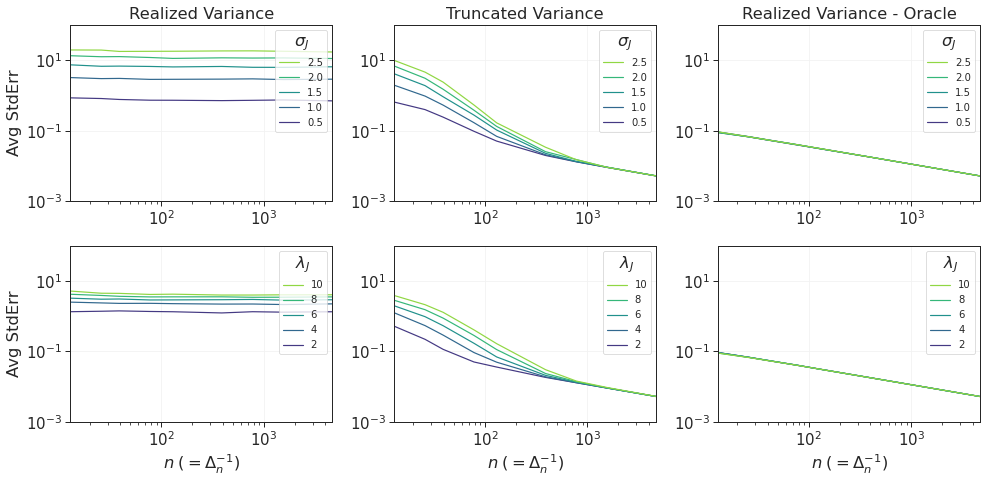

In [1338]:
fig, ax = plt.subplots(figsize=(14, 7), nrows=2, ncols=3)
xlims = [results_df["n"].min(), results_df["n"].max()]
ylims = [1e-3, 1e2]


def plot_helper(ax, x, y, z, plot_data, legend_title, plot_title, y_label, x_label):
    sns.lineplot(
        x=x,
        y=y,
        hue=z,
        palette=sns.color_palette("viridis", len(plot_data[z].unique())),
        data=plot_data,
        ax=ax,
    )
    handles, labels = ax.get_legend_handles_labels()
    plt.legend(handles[::-1], labels[::-1], title=legend_title, fontsize=10, loc="upper right")
    plt.yscale("log")
    plt.xscale("log")
    plt.title(plot_title)
    plt.ylabel(y_label)
    plt.xlabel(x_label)
    plt.xlim(xlims)
    plt.ylim(ylims)


## Vary n on x-axis, vary jump stdev
plot_data = results_df.query('jump_freq == @params_baseline.get("jump_freq")')

plot_helper(
    plt.subplot(231),
    "n",
    "Mean_RV_se",
    "sigma_jumpsize",
    plot_data,
    "$\sigma_J$",
    "Realized Variance",
    "Avg StdErr",
    "",
)
plot_helper(
    plt.subplot(232),
    "n",
    "Mean_TV_se",
    "sigma_jumpsize",
    plot_data,
    "$\sigma_J$",
    "Truncated Variance",
    "",
    "",
)
plot_helper(
    plt.subplot(233),
    "n",
    "Mean_RV_oracle_se",
    "sigma_jumpsize",
    plot_data,
    "$\sigma_J$",
    "Realized Variance - Oracle",
    "",
    "",
)

## Vary n on x-axis, vary jumpfreq
plot_data = results_df.query('sigma_jumpsize == @params_baseline.get("sigma_jumpsize")')

plot_helper(
    plt.subplot(234),
    "n",
    "Mean_RV_se",
    "jump_freq",
    plot_data,
    "$\lambda_J$",
    "",
    "Avg StdErr",
    "$n\; (=\Delta_n^{-1})$",
)
plot_helper(
    plt.subplot(235),
    "n",
    "Mean_TV_se",
    "jump_freq",
    plot_data,
    "$\lambda_J$",
    "",
    "",
    "$n\; (=\Delta_n^{-1})$",
)
plot_helper(
    plt.subplot(236),
    "n",
    "Mean_RV_oracle_se",
    "jump_freq",
    plot_data,
    "$\lambda_J$",
    "",
    "",
    "$n\; (=\Delta_n^{-1})$",
)

plt.tight_layout()
plt.savefig('../exhibits/mean_se_all_subplots.pdf')

**Average Bias**

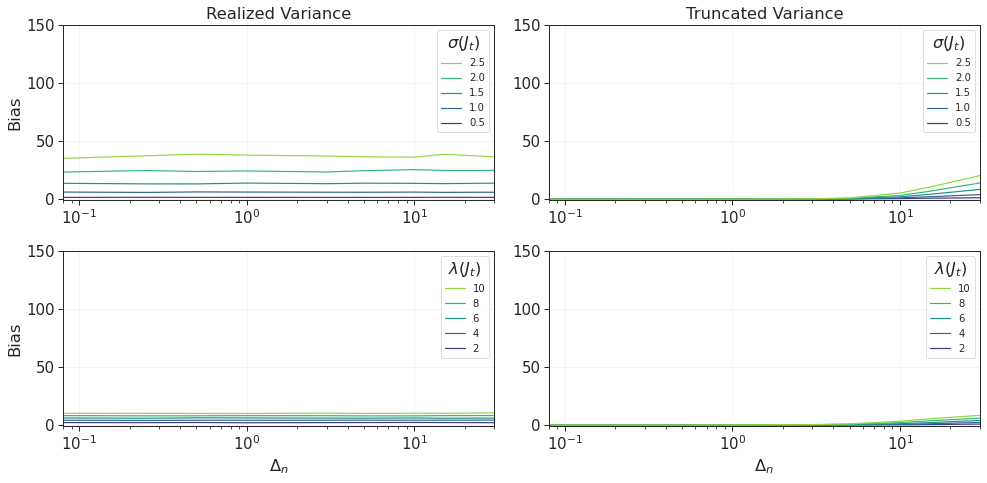

In [1313]:
fig, ax = plt.subplots(figsize=(14, 7), nrows=2, ncols=2)
xlims = [results_df["Delta_n"].min(), results_df["Delta_n"].max()]
ylims = [-1, 150]


def plot_helper(ax, x, y, z, plot_data, legend_title, plot_title, y_label, x_label):
    sns.lineplot(
        x=x,
        y=y,
        hue=z,
        palette=sns.color_palette("viridis", len(plot_data[z].unique())),
        data=plot_data,
        ax=ax,
    )
    handles, labels = ax.get_legend_handles_labels()
    plt.legend(handles[::-1], labels[::-1], title=legend_title, fontsize=10, loc="upper right")
#     plt.yscale("log")
    plt.xscale("log")
    plt.title(plot_title)
    plt.ylabel(y_label)
    plt.xlabel(x_label)
    plt.xlim(xlims)
    plt.ylim(ylims)


## Vary n on x-axis, vary jump stdev
plot_data = results_df.query('jump_freq == @params_baseline.get("jump_freq")')

plot_helper(
    plt.subplot(221),
    "Delta_n",
    "Bias_RV",
    "sigma_jumpsize",
    plot_data,
    "$\sigma(J_t)$",
    "Realized Variance",
    "Bias",
    "",
)
plot_helper(
    plt.subplot(222),
    "Delta_n",
    "Bias_TV",
    "sigma_jumpsize",
    plot_data,
    "$\sigma(J_t)$",
    "Truncated Variance",
    "",
    "",
)

## Vary n on x-axis, vary jumpfreq
plot_data = results_df.query('sigma_jumpsize == @params_baseline.get("sigma_jumpsize")')

plot_helper(
    plt.subplot(223),
    "Delta_n",
    "Bias_RV",
    "jump_freq",
    plot_data,
    "$\lambda(J_t)$",
    "",
    "Bias",
    "$\Delta_n$",
)
plot_helper(
    plt.subplot(224),
    "Delta_n",
    "Bias_TV",
    "jump_freq",
    plot_data,
    "$\lambda(J_t)$",
    "",
    "",
    "$\Delta_n$",
)

plt.tight_layout()

**Average Type I and II Error**

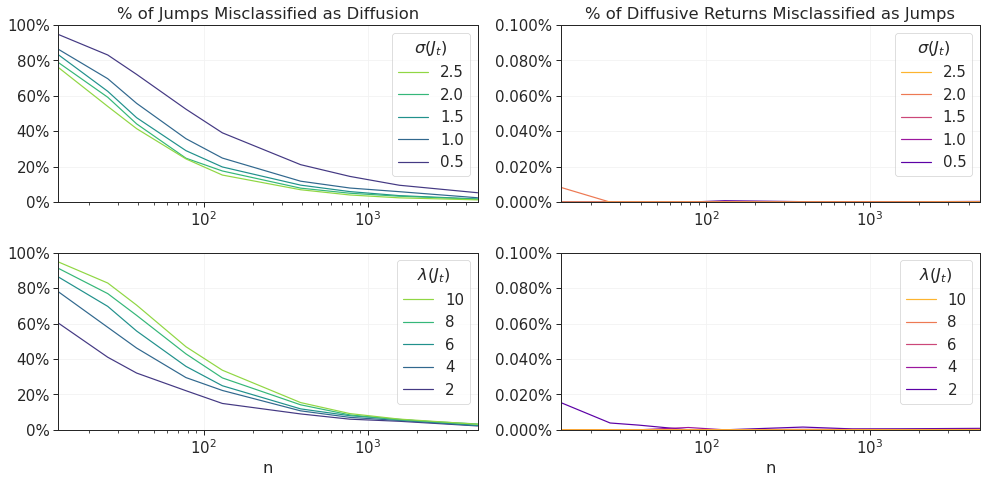

In [1371]:
fig, ax = plt.subplots(figsize=(14, 7), nrows=2, ncols=2)
xlims = [min(n_range), max(n_range)]
ylims_1 = [0, 1]
ylims_2 = [0, 1e-3]

## Vary n on x-axis, vary jump stdev
plot_data = results_df.query('jump_freq == @params_baseline.get("jump_freq")')

# Type I - n & sigma_jumpsize
ax = plt.subplot(221)
sns.lineplot(
    x="n",
    y="BV_avg_t1",
    hue="sigma_jumpsize",
    palette=sns.color_palette("viridis", len(plot_data["sigma_jumpsize"].unique())),
    data=plot_data,
    ax=ax,
)
handles, labels = ax.get_legend_handles_labels()
plt.legend(handles[::-1], labels[::-1], title="$\sigma(J_t)$", loc="upper right")
plt.xscale("log")
plt.title('% of Jumps Misclassified as Diffusion')
plt.ylabel('')
plt.xlabel('')
plt.xlim(xlims)
plt.ylim(ylims_1)
ax.yaxis.set_major_formatter(matplotlib.ticker.PercentFormatter(1.0))

# Type II - n & sigma_jumpsize
ax = plt.subplot(222)
sns.lineplot(
    x="n",
    y="BV_avg_t2",
    hue="sigma_jumpsize",
    palette=sns.color_palette("plasma", len(plot_data["sigma_jumpsize"].unique())),
    data=plot_data,
    ax=ax,
)
handles, labels = ax.get_legend_handles_labels()
plt.legend(handles[::-1], labels[::-1], title="$\sigma(J_t)$", loc="upper right")
plt.xscale("log")
plt.title('% of Diffusive Returns Misclassified as Jumps')
plt.ylabel('')
plt.xlabel('')
plt.xlim(xlims)
plt.ylim(ylims_2)
ax.yaxis.set_major_formatter(matplotlib.ticker.PercentFormatter(1.0))

## Vary n on x-axis, vary jumpsize
plot_data = results_df.query('sigma_jumpsize == @params_baseline.get("sigma_jumpsize")')

# Type I - n & jump_freq
ax = plt.subplot(223)
sns.lineplot(
    x="n",
    y="BV_avg_t1",
    hue="jump_freq",
    palette=sns.color_palette("viridis", len(plot_data["jump_freq"].unique())),
    data=plot_data,
    ax=ax,
)
handles, labels = ax.get_legend_handles_labels()
plt.legend(handles[::-1], labels[::-1], title="$\lambda(J_t)$", loc="upper right")
plt.xscale("log")
plt.ylabel('')
plt.xlabel('n')
plt.xlim(xlims)
plt.ylim(ylims_1)
ax.yaxis.set_major_formatter(matplotlib.ticker.PercentFormatter(1.0))

# Type II - n & jump_freq
ax = plt.subplot(224)
sns.lineplot(
    x="n",
    y="BV_avg_t2",
    hue="jump_freq",
    palette=sns.color_palette("plasma", len(plot_data["jump_freq"].unique())),
    data=plot_data,
    ax=ax,
)
handles, labels = ax.get_legend_handles_labels()
plt.legend(handles[::-1], labels[::-1], title="$\lambda(J_t)$", loc="upper right")
plt.xscale("log")
plt.ylabel('')
plt.xlabel('n')
plt.xlim(xlims)
plt.ylim(ylims_2)
ax.yaxis.set_major_formatter(matplotlib.ticker.PercentFormatter(1.0))

plt.tight_layout()
plt.savefig('../exhibits/classification_accuracy.pdf')

**Distribution of t-stats**

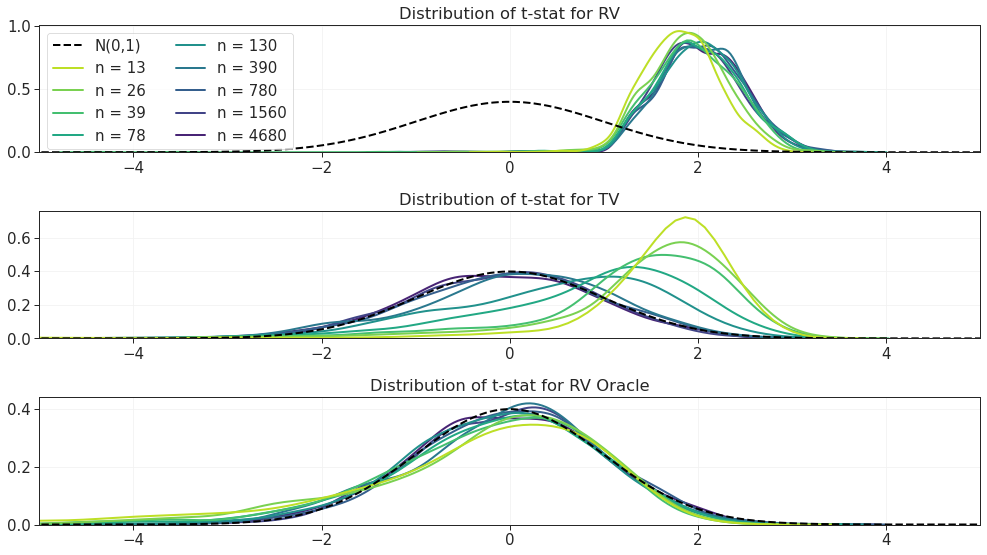

In [1373]:
fig, ax = plt.subplots(figsize=(14, 8), nrows=3, ncols=1)
xlims = [-5, 5]
# ylims = [0, 1]

## Vary n on x-axis, vary jump stdev
plot_data = results_df.query(
    'jump_freq == @params_baseline.get("jump_freq") &'
    + 'sigma_jumpsize == @params_baseline.get("sigma_jumpsize")'
)

# RV
ax = plt.subplot(311)
for i in range(len(n_range)):
    n = n_range[i]
    sns.kdeplot(
        x=plot_data.query("n == @n")["tstats_RV"].iloc[0],
        color=sns.color_palette("viridis", len(n_range))[i],
        label=f'n = {n}',
        lw=2,
        ax=ax,
    )
normal_x = np.random.normal(0,3,999)
sns.lineplot(x = normal_x, y = stats.norm.pdf(normal_x), label = 'N(0,1)',lw = 2, ls = 'dashed', color = 'k')
handles, labels = ax.get_legend_handles_labels()
plt.legend(handles[::-1], labels[::-1], title="", loc="upper left", ncol=2)
plt.title("Distribution of t-stat for RV")
plt.ylabel("")
plt.xlabel("")
plt.xlim(xlims)


ax = plt.subplot(312)
for i in range(len(n_range)):
    n = n_range[i]
    sns.kdeplot(
        x=plot_data.query("n == @n")["tstats_TV"].iloc[0],
        color=sns.color_palette("viridis", len(n_range))[i],
        lw=2,
        ax=ax,
    )
sns.lineplot(x = normal_x, y = stats.norm.pdf(normal_x), lw = 2, ls = 'dashed', color = 'k')
plt.title("Distribution of t-stat for TV")
plt.ylabel("")
plt.xlabel("")
plt.xlim(xlims)


ax = plt.subplot(313)
for i in range(len(n_range)):
    n = n_range[i]
    sns.kdeplot(
        x=plot_data.query("n == @n")["tstats_RV_oracle"].iloc[0],
        color=sns.color_palette("viridis", len(n_range))[i],
        lw=2,
        ax=ax,
    )
sns.lineplot(x = normal_x, y = stats.norm.pdf(normal_x), lw = 2, ls = 'dashed', color = 'k')
plt.title("Distribution of t-stat for RV Oracle")
plt.ylabel("")
plt.xlabel("")
plt.xlim(xlims)

plt.tight_layout()
plt.savefig('../exhibits/tstats_all_subplots.pdf')

## Tables

### Bias and RMSE

In [1378]:
## RMSE and Bias - n
rmse_bias_table = (
    results_df.query(
        'jump_freq == @params_baseline.get("jump_freq") &'
        + 'sigma_jumpsize == @params_baseline.get("sigma_jumpsize")'
    )
    .groupby(["n", "Delta_n"])[["Bias_RV", "Bias_TV", "Bias_RV_oracle", "RMSE_RV", "RMSE_TV", "RMSE_RV_oracle"]]
    .first()
)
display(rmse_bias_table)
print(rmse_bias_table.round(3).to_latex())

,,Bias_RV,Bias_TV,Bias_RV_oracle,RMSE_RV,RMSE_TV,RMSE_RV_oracle
n,Delta_n,,,,,,
13,30.00,5.917407,3.886661,0.005579,7.669775,5.693866,0.100823
26,15.00,5.817623,2.007484,0.004733,7.347965,3.483147,0.072749
39,10.00,6.036260,1.071292,0.001145,7.498138,2.098403,0.057198
78,5.00,5.881684,0.277483,0.000526,7.384934,0.661193,0.041670
130,3.00,5.925583,0.079675,0.000132,7.193163,0.246979,0.030673
390,1.00,6.068279,0.005204,0.000277,7.460018,0.031864,0.017964
780,0.50,6.165834,0.001025,0.000580,7.568930,0.014537,0.012453
1560,0.25,5.764770,-0.000189,0.000024,7.064013,0.008821,0.008531
4680,0.08,6.056850,-0.000383,-0.000138,7.656781,0.005119,0.005100


\begin{tabular}{llrrrrrr}
\toprule
     &       &  Bias\_RV &  Bias\_TV &  Bias\_RV\_oracle &  RMSE\_RV &  RMSE\_TV &  RMSE\_RV\_oracle \\
n & Delta\_n &          &          &                 &          &          &                 \\
\midrule
13   & 30.00 &    5.917 &    3.887 &           0.006 &    7.670 &    5.694 &           0.101 \\
26   & 15.00 &    5.818 &    2.007 &           0.005 &    7.348 &    3.483 &           0.073 \\
39   & 10.00 &    6.036 &    1.071 &           0.001 &    7.498 &    2.098 &           0.057 \\
78   & 5.00  &    5.882 &    0.277 &           0.001 &    7.385 &    0.661 &           0.042 \\
130  & 3.00  &    5.926 &    0.080 &           0.000 &    7.193 &    0.247 &           0.031 \\
390  & 1.00  &    6.068 &    0.005 &           0.000 &    7.460 &    0.032 &           0.018 \\
780  & 0.50  &    6.166 &    0.001 &           0.001 &    7.569 &    0.015 &           0.012 \\
1560 & 0.25  &    5.765 &   -0.000 &           0.000 &    7.064 &    0.009 &        

In [1379]:
## RMSE and Bias - jump frequency
rmse_bias_table = (
    results_df.query(
        'n == @params_baseline.get("n") &' + 'sigma_jumpsize == @params_baseline.get("sigma_jumpsize")'
    )
    .groupby(["jump_freq"])[["Bias_RV", "Bias_TV", "Bias_RV_oracle", "RMSE_RV", "RMSE_TV", "RMSE_RV_oracle"]]
    .first()
)
display(rmse_bias_table)
print(rmse_bias_table.round(3).to_latex())

,Bias_RV,Bias_TV,Bias_RV_oracle,RMSE_RV,RMSE_TV,RMSE_RV_oracle
jump_freq,,,,,,
2,2.050414,0.018407,0.000287,3.241921,0.087078,0.038063
4,4.133488,0.105713,0.002239,5.556923,0.309661,0.041576
6,5.881684,0.277483,0.000526,7.384934,0.661193,0.041670
8,7.795774,0.571847,0.001739,9.282653,1.050811,0.039011
10,9.899156,0.915017,0.001034,11.375389,1.581759,0.040993


\begin{tabular}{lrrrrrr}
\toprule
{} &  Bias\_RV &  Bias\_TV &  Bias\_RV\_oracle &  RMSE\_RV &  RMSE\_TV &  RMSE\_RV\_oracle \\
jump\_freq &          &          &                 &          &          &                 \\
\midrule
2         &    2.050 &    0.018 &           0.000 &    3.242 &    0.087 &           0.038 \\
4         &    4.133 &    0.106 &           0.002 &    5.557 &    0.310 &           0.042 \\
6         &    5.882 &    0.277 &           0.001 &    7.385 &    0.661 &           0.042 \\
8         &    7.796 &    0.572 &           0.002 &    9.283 &    1.051 &           0.039 \\
10        &    9.899 &    0.915 &           0.001 &   11.375 &    1.582 &           0.041 \\
\bottomrule
\end{tabular}



In [1380]:
## RMSE and Bias - jump size
rmse_bias_table = (
    results_df.query(
        'n == @params_baseline.get("n") &' + 'jump_freq == @params_baseline.get("jump_freq")'
    )
    .groupby(["sigma_jumpsize"])[["Bias_RV", "Bias_TV", "Bias_RV_oracle", "RMSE_RV", "RMSE_TV", "RMSE_RV_oracle"]]
    .first()
)
display(rmse_bias_table)
print(rmse_bias_table.round(3).to_latex())

,Bias_RV,Bias_TV,Bias_RV_oracle,RMSE_RV,RMSE_TV,RMSE_RV_oracle
sigma_jumpsize,,,,,,
0.5,1.473563,0.141503,-0.001762,1.839449,0.250569,0.039225
1.0,5.881684,0.277483,0.000526,7.384934,0.661193,0.041670
1.5,13.729076,0.491056,0.000760,16.981045,1.515701,0.040501
2.0,24.486939,0.671127,0.000178,30.081207,1.854596,0.040002
2.5,36.459173,0.986759,0.001337,45.323142,3.158875,0.039113


\begin{tabular}{lrrrrrr}
\toprule
{} &  Bias\_RV &  Bias\_TV &  Bias\_RV\_oracle &  RMSE\_RV &  RMSE\_TV &  RMSE\_RV\_oracle \\
sigma\_jumpsize &          &          &                 &          &          &                 \\
\midrule
0.5            &    1.474 &    0.142 &          -0.002 &    1.839 &    0.251 &           0.039 \\
1.0            &    5.882 &    0.277 &           0.001 &    7.385 &    0.661 &           0.042 \\
1.5            &   13.729 &    0.491 &           0.001 &   16.981 &    1.516 &           0.041 \\
2.0            &   24.487 &    0.671 &           0.000 &   30.081 &    1.855 &           0.040 \\
2.5            &   36.459 &    0.987 &           0.001 &   45.323 &    3.159 &           0.039 \\
\bottomrule
\end{tabular}



### Coverage Rates

In [1382]:
## Coverage Rates - n
coverage_rate_table = (
    results_df.query(
        'jump_freq == @params_baseline.get("jump_freq") &'
        + 'sigma_jumpsize == @params_baseline.get("sigma_jumpsize")'
    )
    .groupby(["n", "Delta_n"])[
        [
            "coverage_90_RV",
            "coverage_90_TV",
            "coverage_90_RV_oracle",
            "coverage_95_RV",
            "coverage_95_TV",
            "coverage_95_RV_oracle",
            "coverage_99_RV",
            "coverage_99_TV",
            "coverage_99_RV_oracle",
        ]
    ]
    .first()
)
coverage_rate_table.columns = [x[9:] for x in coverage_rate_table.columns]
display(coverage_rate_table)
print(coverage_rate_table.round(4).to_latex())

,,90_RV,90_TV,90_RV_oracle,95_RV,95_TV,95_RV_oracle,99_RV,99_TV,99_RV_oracle
n,Delta_n,,,,,,,,,
13,30.00,0.332,0.366,0.833,0.635,0.625,0.869,0.968,0.955,0.911
26,15.00,0.264,0.442,0.845,0.560,0.647,0.888,0.950,0.933,0.943
39,10.00,0.234,0.552,0.882,0.513,0.700,0.919,0.921,0.947,0.962
78,5.00,0.203,0.715,0.872,0.479,0.842,0.926,0.902,0.969,0.972
130,3.00,0.203,0.824,0.903,0.440,0.910,0.947,0.898,0.981,0.983
390,1.00,0.176,0.862,0.883,0.440,0.932,0.942,0.898,0.987,0.989
780,0.50,0.177,0.891,0.903,0.437,0.945,0.952,0.883,0.987,0.987
1560,0.25,0.213,0.909,0.917,0.489,0.963,0.968,0.903,0.993,0.992
4680,0.08,0.182,0.898,0.897,0.452,0.950,0.952,0.895,0.990,0.991


\begin{tabular}{llrrrrrrrrr}
\toprule
     &       &  90\_RV &  90\_TV &  90\_RV\_oracle &  95\_RV &  95\_TV &  95\_RV\_oracle &  99\_RV &  99\_TV &  99\_RV\_oracle \\
n & Delta\_n &        &        &               &        &        &               &        &        &               \\
\midrule
13   & 30.00 &  0.332 &  0.366 &         0.833 &  0.635 &  0.625 &         0.869 &  0.968 &  0.955 &         0.911 \\
26   & 15.00 &  0.264 &  0.442 &         0.845 &  0.560 &  0.647 &         0.888 &  0.950 &  0.933 &         0.943 \\
39   & 10.00 &  0.234 &  0.552 &         0.882 &  0.513 &  0.700 &         0.919 &  0.921 &  0.947 &         0.962 \\
78   & 5.00  &  0.203 &  0.715 &         0.872 &  0.479 &  0.842 &         0.926 &  0.902 &  0.969 &         0.972 \\
130  & 3.00  &  0.203 &  0.824 &         0.903 &  0.440 &  0.910 &         0.947 &  0.898 &  0.981 &         0.983 \\
390  & 1.00  &  0.176 &  0.862 &         0.883 &  0.440 &  0.932 &         0.942 &  0.898 &  0.987 &         0.989 